<a href="https://colab.research.google.com/github/hueglijoshua/CVI03.HS24-Computer-Vision/blob/main/04_object_detection_incl_non_fractured.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import json
import shutil
import xml.etree.ElementTree as ET
import pandas as pd
import yaml
import numpy as np
from datetime import datetime
import shutil
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Image
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, auc
import random

# Object detection using YOLO bounding boxes incl. not factured images

We are going to use the YOLO model provided by ultralytics

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [3]:
from ultralytics import YOLO
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


In [4]:
# Set dataset path
dataset_path = "/content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo"

# Verify the dataset structure
print(os.listdir(dataset_path))

# model_path = "/content/drive/MyDrive/yolo_models/yolov8l_2025-02-07_18-23-13.pt"
model_path = None

['data.yaml', 'images', 'labels', 'classes.txt']


100%|██████████| 83.7M/83.7M [00:00<00:00, 294MB/s]


Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/data.yaml, epochs=200, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

train: Scanning /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/labels/train... 1139 images, 565 backgrounds, 9 corrupt: 100%|██████████| 1148/1148 [00:31<00:00, 36.96it/s] 

train: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/train/IMG0004036.jpg: ignoring corrupt image/label: image file is truncated (14 bytes not processed)
train: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/train/IMG0004098.jpg: ignoring corrupt image/label: image file is truncated (17 bytes not processed)
train: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/train/IMG0004100.jpg: ignoring corrupt image/label: image file is truncated (15 bytes not processed)
train: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/train/IMG0004130.jpg: ignoring corrupt image/label: image file is truncated (8 bytes not processed)
train: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/train/IMG0004148.jpg: ignoring corrupt image/label: image file is truncated (14 bytes not processed)
train: WARNING ⚠️ /content

train: New cache created: /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/labels/val... 159 images, 77 backgrounds, 5 corrupt: 100%|██████████| 164/164 [00:05<00:00, 31.55it/s]

val: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/val/IMG0004029.jpg: ignoring corrupt image/label: image file is truncated (22 bytes not processed)
val: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/val/IMG0004252.jpg: ignoring corrupt image/label: image file is truncated (67 bytes not processed)
val: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/val/IMG0004256.jpg: ignoring corrupt image/label: image file is truncated (66 bytes not processed)
val: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/val/IMG0004279.jpg: ignoring corrupt image/label: image file is truncated (5 bytes not processed)
val: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/val/IMG0004285.jpg: ignoring corrupt image/label: image file is truncated (9 bytes not processed)


val: New cache created: /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/labels/val.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      10.6G      3.026      6.088      2.147          2        640: 100%|██████████| 72/72 [01:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

                   all        159         91          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      10.5G      3.104      3.913      2.219          3        640: 100%|██████████| 72/72 [00:58<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        159         91          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      10.5G      3.203      3.778      2.248          3        640: 100%|██████████| 72/72 [00:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all        159         91   0.000163      0.022   9.18e-05   3.17e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      10.5G      3.023      3.356      2.077          3        640: 100%|██████████| 72/72 [00:56<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        159         91      0.258     0.0769     0.0571    0.00891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      10.5G      3.061      3.491      2.145          2        640: 100%|██████████| 72/72 [00:57<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        159         91     0.0939      0.033     0.0207     0.0045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      10.5G      2.927      3.467      2.118          3        640: 100%|██████████| 72/72 [00:57<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]

                   all        159         91      0.146     0.0657     0.0344      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      10.5G      2.928      3.322      2.043          7        640: 100%|██████████| 72/72 [00:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

                   all        159         91    0.00382     0.0769    0.00371     0.0015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      10.5G      2.796      3.168      2.001          5        640: 100%|██████████| 72/72 [00:56<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

                   all        159         91     0.0165      0.154     0.0471     0.0145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      10.5G      2.737      3.077      1.877          3        640: 100%|██████████| 72/72 [00:58<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

                   all        159         91      0.162       0.11     0.0485     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      10.5G      2.767      2.954      1.914          3        640: 100%|██████████| 72/72 [00:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        159         91      0.246     0.0659     0.0538     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      10.5G      2.732      3.095      1.918          1        640: 100%|██████████| 72/72 [00:56<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

                   all        159         91      0.139      0.121     0.0653     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      10.5G      2.726      3.016      1.951          3        640: 100%|██████████| 72/72 [00:58<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

                   all        159         91      0.256      0.132     0.0927     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      10.6G      2.649      2.931      1.917          5        640: 100%|██████████| 72/72 [00:57<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        159         91      0.126     0.0549     0.0507     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      10.6G      2.598      2.826      1.806          0        640: 100%|██████████| 72/72 [00:56<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

                   all        159         91      0.134       0.11     0.0311    0.00927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      10.5G       2.63      2.807      1.878          2        640: 100%|██████████| 72/72 [00:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all        159         91      0.258     0.0879     0.0861     0.0234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      10.5G      2.599      2.821      1.816          4        640: 100%|██████████| 72/72 [00:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

                   all        159         91      0.235       0.22      0.125      0.037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      10.5G      2.568      2.784      1.834          0        640: 100%|██████████| 72/72 [00:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

                   all        159         91      0.188      0.154      0.102     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      10.6G      2.564      2.734      1.842          1        640: 100%|██████████| 72/72 [00:56<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]

                   all        159         91      0.251      0.143      0.127     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      10.5G      2.551       2.65      1.846          2        640: 100%|██████████| 72/72 [00:57<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]

                   all        159         91      0.178      0.198      0.125     0.0365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      10.5G      2.526      2.691       1.79          5        640: 100%|██████████| 72/72 [00:57<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all        159         91      0.237      0.165      0.137     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      10.5G      2.475      2.662      1.779          5        640: 100%|██████████| 72/72 [00:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

                   all        159         91      0.461      0.187      0.158     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      10.5G      2.475      2.593      1.824          2        640: 100%|██████████| 72/72 [00:58<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all        159         91      0.261      0.253      0.188     0.0524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      10.6G      2.527      2.557      1.773          3        640: 100%|██████████| 72/72 [00:57<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        159         91     0.0711     0.0769     0.0306     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      10.5G      2.489       2.57      1.772          0        640: 100%|██████████| 72/72 [00:57<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        159         91       0.17      0.154      0.092     0.0351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      10.5G      2.446      2.513      1.745          4        640: 100%|██████████| 72/72 [00:58<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]

                   all        159         91      0.236      0.165      0.135     0.0459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      10.5G      2.438      2.444      1.762          6        640: 100%|██████████| 72/72 [00:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all        159         91       0.36      0.176      0.162     0.0542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      10.5G      2.464      2.481      1.738          1        640: 100%|██████████| 72/72 [00:56<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

                   all        159         91      0.176     0.0989     0.0778     0.0265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      10.6G      2.419      2.488      1.709          4        640: 100%|██████████| 72/72 [00:57<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all        159         91      0.211       0.11      0.136     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      10.8G      2.368      2.491      1.734          0        640: 100%|██████████| 72/72 [00:57<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all        159         91      0.191      0.143      0.145     0.0393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      10.8G      2.433       2.44      1.771          1        640: 100%|██████████| 72/72 [00:56<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

                   all        159         91      0.296      0.154      0.169     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      10.5G      2.424      2.408      1.749          3        640: 100%|██████████| 72/72 [00:56<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]

                   all        159         91      0.375      0.198      0.169     0.0517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      10.5G      2.349      2.358      1.706          1        640: 100%|██████████| 72/72 [00:56<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

                   all        159         91      0.206      0.211      0.149     0.0487
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 22, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



32 epochs completed in 0.625 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 87.6MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


                   all        159         91      0.261      0.253      0.188     0.0524
Speed: 0.2ms preprocess, 13.7ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/detect/train3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

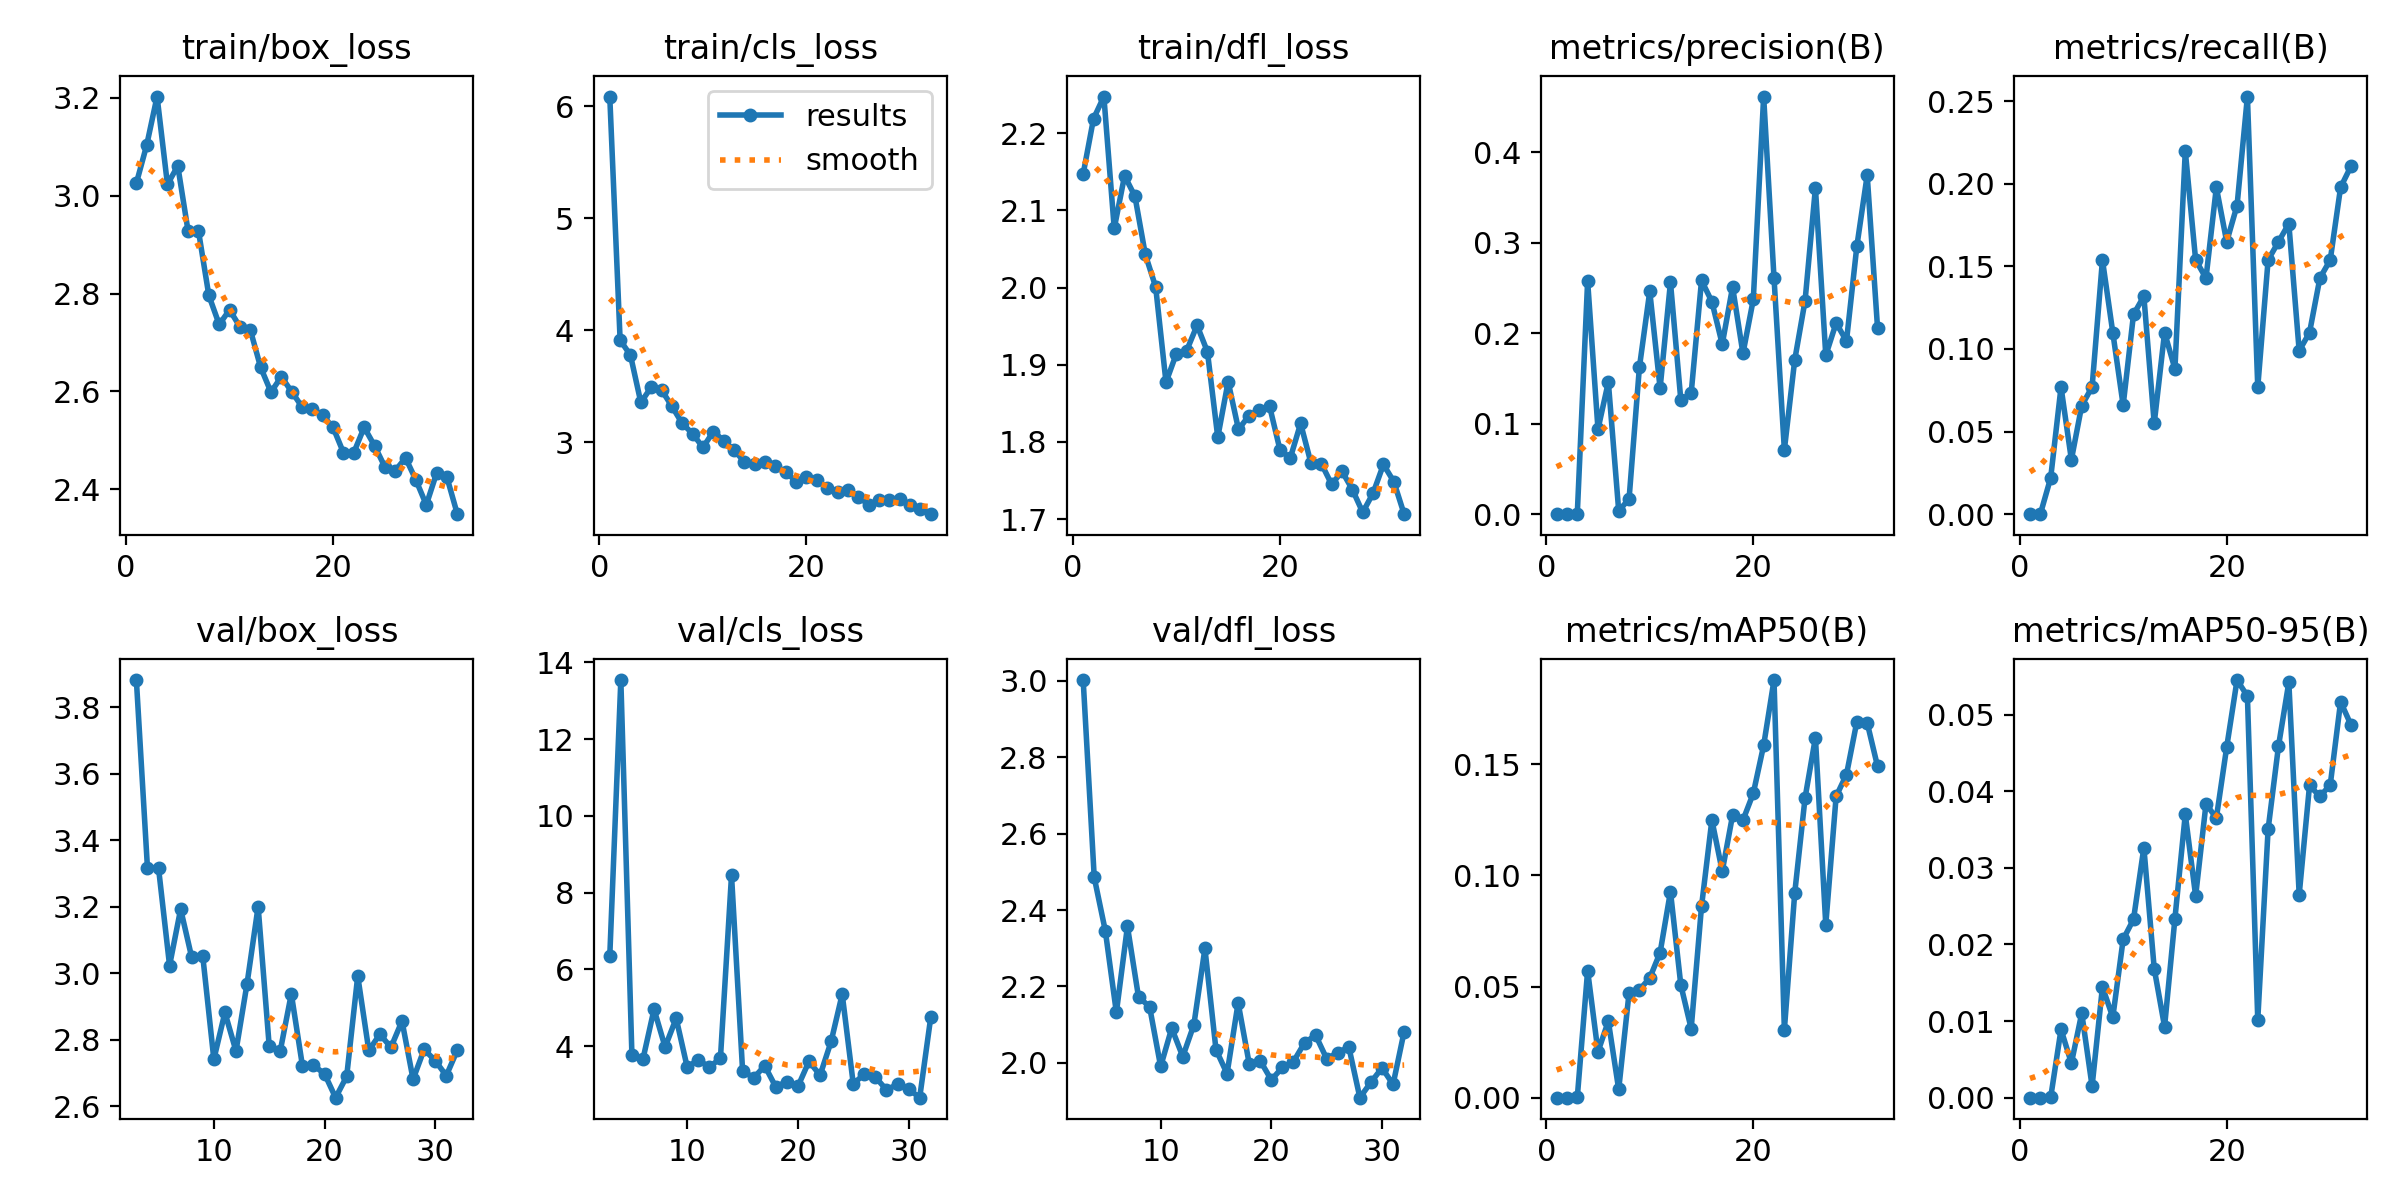

In [7]:
if model_path is None:
    # Train YOLO model
    model_ver = "yolov8l"  # e.g. Use "n" for a lightweight model

    model = YOLO(f"{model_ver}.pt")
    results = model.train(data=f"{dataset_path}/data.yaml",
                          epochs=200,
                          imgsz=640,
                          patience=10,
                          val = True)

    from google.colab import files

    best_model_path = os.path.join(str(model.trainer.save_dir), "weights", "best.pt")

    files.download(best_model_path)

    # Define the target directory in Google Drive
    drive_save_dir = "/content/drive/MyDrive/yolo_models"

    # Create the directory if it doesn't exist
    os.makedirs(drive_save_dir, exist_ok=True)

    # Generate a timestamped filename
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_filename = f"{model_ver}_incl_not_fractured_{timestamp}.pt"

    save_path = os.path.join(drive_save_dir, model_filename)

    shutil.copy(best_model_path, save_path)

    # Display the loss curves
    display(Image(filename= f"{os.path.join(str(model.trainer.save_dir))}/results.png"))


In [17]:
import os

# Define the paths to your dataset
yolo_data_dir = dataset_path
splits = ["train", "val", "test"]

# Iterate through each dataset split
for split in splits:
    img_dir = os.path.join(yolo_data_dir, "images", split)
    ann_dir = os.path.join(yolo_data_dir, "labels", split)

    # List all image files (without extension)
    image_files = {os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith((".jpg", ".png", ".jpeg"))}

    # List all annotation files (without extension)
    annotation_files = {os.path.splitext(f)[0] for f in os.listdir(ann_dir) if f.endswith(".txt")}

    # Find missing annotations
    missing_annotations = image_files - annotation_files
    missing_images = annotation_files - image_files  # In case there are extra annotation files

    print(f"\nChecking split: {split}")
    if missing_annotations:
        print(f"⚠️ Missing annotation files for {len(missing_annotations)} images:")
        print("\n".join(sorted(missing_annotations)[:10]))  # Show first 10 missing files

    if missing_images:
        print(f"⚠️ Extra annotation files found without images: {len(missing_images)}")
        print("\n".join(sorted(missing_images)[:10]))

    if not missing_annotations and not missing_images:
        print("✅ All images have corresponding annotation files!")

print("\nAnnotation check completed.")



Checking split: train
✅ All images have corresponding annotation files!

Checking split: val
✅ All images have corresponding annotation files!

Checking split: test
✅ All images have corresponding annotation files!

Annotation check completed.


In [8]:
# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
print(f"mAP50-95 = {metrics.box.map:.3f}")
print(f"mAP50 = {metrics.box.map50:.3f}")
print(f"mAP75 = {metrics.box.map75:.3f}")
metrics.box.maps  # a list contains map50-95 of each category

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/labels/val.cache... 159 images, 77 backgrounds, 5 corrupt: 100%|██████████| 164/164 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/val/IMG0004029.jpg: ignoring corrupt image/label: image file is truncated (22 bytes not processed)
val: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/val/IMG0004252.jpg: ignoring corrupt image/label: image file is truncated (67 bytes not processed)
val: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/val/IMG0004256.jpg: ignoring corrupt image/label: image file is truncated (66 bytes not processed)
val: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/val/IMG0004279.jpg: ignoring corrupt image/label: image file is truncated (5 bytes not processed)
val: WARNING ⚠️ /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/val/IMG0004285.jpg: ignoring corrupt image/label: image file is truncated (9 bytes not processed)



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


                   all        159         91      0.237      0.242      0.173     0.0518
Speed: 0.2ms preprocess, 32.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train32
mAP50-95 = 0.052
mAP50 = 0.173
mAP75 = 0.018


array([   0.051789])

In [9]:
def intersection_over_union(boxA, boxB):
    """
    Computes IoU between two boxes: [xmin, ymin, xmax, ymax].
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = boxAArea + boxBArea - interArea + 1e-6

    return interArea / union

def match_boxes_iou(pred_boxes, gt_boxes, iou_thresh):
    """
    Matches predicted boxes with ground truth based on IoU threshold.
    Returns:
      - is_tp: List of booleans indicating if a predicted box is a true positive.
      - is_fp: List of booleans indicating if a predicted box is a false positive.
      - unmatched_gt: Count of unmatched ground truth boxes (False Negatives).
    """
    used = np.zeros(len(gt_boxes), dtype=bool)  # Tracks matched GT boxes
    is_tp = []
    is_fp = []

    for pb in pred_boxes:
        best_iou = 0.0
        best_idx = -1
        for i, gb in enumerate(gt_boxes):
            if used[i]:
                continue  # Skip already matched GT boxes
            iou = intersection_over_union(pb, gb)

            if iou > best_iou:
                best_iou = iou
                best_idx = i

        if best_iou >= iou_thresh and best_idx >= 0:
            is_tp.append(True)
            is_fp.append(False)
            used[best_idx] = True  # Mark this GT as matched
        else:
            is_tp.append(False)
            is_fp.append(True)  # Count this as a false positive

    unmatched_gt = np.sum(~used)  # False Negatives = Unmatched GT boxes
    return np.array(is_tp), np.array(is_fp), unmatched_gt



In [22]:
test_images_dir = f"{dataset_path}/images/test"
test_labels_dir = f"{dataset_path}/labels/test"

test_images = [f for f in os.listdir(test_images_dir)
               if f.lower().endswith((".jpg", ".png", ".jpeg"))]

# We want the class ID for "fractured"
fractured_id = None
for idx, name in model.names.items():
    if name == "fractured":
        fractured_id = idx
        break

if fractured_id is None:
    raise ValueError("No class named 'fractured' in model.names!")

print(f"Class ID for 'fractured': {fractured_id}")

Class ID for 'fractured': 0


In [23]:
# storing a list of ground truth boxes (only 'fractured')
# and a list of predicted boxes (only 'fractured'), plus the predicted scores.
all_gt = []
all_pred = []
all_scores = []

for image_name in tqdm(test_images):
    image_path = os.path.join(test_images_dir, image_name)
    label_path = os.path.join(test_labels_dir, os.path.splitext(image_name)[0] + ".txt")

    # Ground truth boxes (for 'fractured')
    image = cv2.imread(image_path)
    if image is None:
        # skip broken image
        continue
    img_h, img_w = image.shape[:2]

    gt_boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                xc, yc, w, h = map(float, parts[1:])
                if cls_id == fractured_id:
                    xmin = int((xc - w/2) * img_w)
                    ymin = int((yc - h/2) * img_h)
                    xmax = int((xc + w/2) * img_w)
                    ymax = int((yc + h/2) * img_h)
                    gt_boxes.append([xmin, ymin, xmax, ymax])

    # Predictions (for 'fractured')
    results = model(image_path, imgsz=640)
    # results = model(image_path, imgsz=640, conf=0.01)

    pred_boxes = []
    scores = []
    for r in results:
        for box in r.boxes:
            cls_pred = int(box.cls[0].item())
            conf = float(box.conf[0].item())
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            if cls_pred == fractured_id:
                pred_boxes.append([x1, y1, x2, y2])
                scores.append(conf)

    all_gt.append(gt_boxes)
    all_pred.append(pred_boxes)
    all_scores.append(scores)

  0%|          | 0/122 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001782.jpg: 640x544 (no detections), 82.3ms
Speed: 4.6ms preprocess, 82.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


  1%|          | 1/122 [00:00<01:41,  1.20it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001566.jpg: 544x640 (no detections), 146.9ms
Speed: 19.2ms preprocess, 146.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


  2%|▏         | 2/122 [00:02<02:28,  1.24s/it]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001611.jpg: 640x544 1 fractured, 53.5ms
Speed: 3.7ms preprocess, 53.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


  2%|▏         | 3/122 [00:02<01:29,  1.33it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001406.jpg: 544x640 1 fractured, 61.7ms
Speed: 4.1ms preprocess, 61.7ms inference, 4.3ms postprocess per image at shape (1, 3, 544, 640)


  3%|▎         | 4/122 [00:02<01:14,  1.58it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001563.jpg: 640x544 (no detections), 61.7ms
Speed: 3.7ms preprocess, 61.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001540.jpg: 640x544 (no detections), 61.2ms
Speed: 3.4ms preprocess, 61.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


  5%|▍         | 6/122 [00:03<00:40,  2.89it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001516.jpg: 544x640 (no detections), 62.5ms
Speed: 7.6ms preprocess, 62.5ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)


  6%|▌         | 7/122 [00:03<00:33,  3.48it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001515.jpg: 640x544 (no detections), 74.3ms
Speed: 3.3ms preprocess, 74.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 544)


  7%|▋         | 8/122 [00:03<00:28,  4.06it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001501.jpg: 640x544 (no detections), 42.6ms
Speed: 12.2ms preprocess, 42.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001506.jpg: 640x544 (no detections), 75.5ms
Speed: 3.8ms preprocess, 75.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 544)


  8%|▊         | 10/122 [00:03<00:21,  5.31it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001528.jpg: 640x544 (no detections), 52.5ms
Speed: 3.6ms preprocess, 52.5ms inference, 7.7ms postprocess per image at shape (1, 3, 640, 544)


  9%|▉         | 11/122 [00:03<00:18,  5.94it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001482.jpg: 544x640 (no detections), 74.6ms
Speed: 8.5ms preprocess, 74.6ms inference, 8.4ms postprocess per image at shape (1, 3, 544, 640)


 10%|▉         | 12/122 [00:03<00:17,  6.22it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001195.jpg: 640x544 (no detections), 43.9ms
Speed: 3.4ms preprocess, 43.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001297.jpg: 640x544 (no detections), 41.9ms
Speed: 3.3ms preprocess, 41.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 11%|█▏        | 14/122 [00:04<00:13,  8.02it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001014.jpg: 640x544 (no detections), 42.0ms
Speed: 3.3ms preprocess, 42.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001170.jpg: 544x640 (no detections), 41.9ms
Speed: 3.2ms preprocess, 41.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 13%|█▎        | 16/122 [00:04<00:11,  9.63it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001263.jpg: 640x544 (no detections), 31.8ms
Speed: 3.3ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001079.jpg: 640x544 (no detections), 30.4ms
Speed: 3.3ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 15%|█▍        | 18/122 [00:04<00:09, 11.30it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001227.jpg: 544x640 (no detections), 30.9ms
Speed: 3.3ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001130.jpg: 544x640 (no detections), 28.0ms
Speed: 3.7ms preprocess, 28.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


 16%|█▋        | 20/122 [00:04<00:07, 12.82it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000957.jpg: 544x640 (no detections), 36.3ms
Speed: 4.3ms preprocess, 36.3ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000854.jpg: 640x544 (no detections), 43.9ms
Speed: 3.3ms preprocess, 43.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 544)


 18%|█▊        | 22/122 [00:04<00:08, 11.86it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000288.jpg: 640x544 (no detections), 101.8ms
Speed: 18.5ms preprocess, 101.8ms inference, 9.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000465.jpg: 544x640 (no detections), 96.0ms
Speed: 10.6ms preprocess, 96.0ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)


 20%|█▉        | 24/122 [00:04<00:10,  8.99it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000827.jpg: 544x640 (no detections), 90.9ms
Speed: 14.1ms preprocess, 90.9ms inference, 6.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000597.jpg: 640x544 (no detections), 28.7ms
Speed: 4.1ms preprocess, 28.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 21%|██▏       | 26/122 [00:05<00:10,  8.92it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000693.jpg: 640x544 (no detections), 28.8ms
Speed: 3.3ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000354.jpg: 640x544 (no detections), 28.8ms
Speed: 3.4ms preprocess, 28.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 23%|██▎       | 28/122 [00:05<00:09, 10.24it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000574.jpg: 544x640 (no detections), 29.4ms
Speed: 3.3ms preprocess, 29.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0000111.jpg: 640x512 (no detections), 69.6ms
Speed: 4.8ms preprocess, 69.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


 25%|██▍       | 30/122 [00:05<00:11,  8.01it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003587.jpg: 640x544 1 fractured, 36.1ms
Speed: 9.0ms preprocess, 36.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 544)


 25%|██▌       | 31/122 [00:06<00:16,  5.58it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003458.jpg: 640x544 (no detections), 29.1ms
Speed: 3.5ms preprocess, 29.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 26%|██▌       | 32/122 [00:06<00:18,  4.80it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003654.jpg: 640x544 (no detections), 28.8ms
Speed: 4.0ms preprocess, 28.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 27%|██▋       | 33/122 [00:06<00:22,  4.02it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003509.jpg: 640x544 (no detections), 29.1ms
Speed: 4.1ms preprocess, 29.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 544)


 28%|██▊       | 34/122 [00:07<00:22,  3.89it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003331.jpg: 640x544 (no detections), 55.6ms
Speed: 3.6ms preprocess, 55.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 29%|██▊       | 35/122 [00:07<00:27,  3.20it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003309.jpg: 544x640 (no detections), 61.9ms
Speed: 4.2ms preprocess, 61.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


 30%|██▉       | 36/122 [00:07<00:28,  3.01it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003342.jpg: 640x544 (no detections), 61.4ms
Speed: 2.5ms preprocess, 61.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 30%|███       | 37/122 [00:08<00:29,  2.93it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003524.jpg: 640x544 (no detections), 60.5ms
Speed: 3.5ms preprocess, 60.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 31%|███       | 38/122 [00:09<00:42,  1.98it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003381.jpg: 640x544 1 fractured, 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 32%|███▏      | 39/122 [00:09<00:38,  2.15it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003619.jpg: 640x544 (no detections), 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 33%|███▎      | 40/122 [00:10<00:36,  2.27it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003374.jpg: 640x544 (no detections), 60.6ms
Speed: 2.4ms preprocess, 60.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▎      | 41/122 [00:10<00:40,  1.98it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003565.jpg: 640x544 1 fractured, 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 34%|███▍      | 42/122 [00:11<00:39,  2.05it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003395.jpg: 640x544 (no detections), 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 35%|███▌      | 43/122 [00:11<00:39,  1.98it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003339.jpg: 640x544 (no detections), 60.5ms
Speed: 3.1ms preprocess, 60.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 36%|███▌      | 44/122 [00:12<00:37,  2.06it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003382.jpg: 640x544 (no detections), 60.4ms
Speed: 2.5ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 37%|███▋      | 45/122 [00:13<01:07,  1.14it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003332.jpg: 640x544 (no detections), 60.4ms
Speed: 3.4ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 38%|███▊      | 46/122 [00:14<01:00,  1.25it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003686.jpg: 640x544 1 fractured, 60.4ms
Speed: 3.3ms preprocess, 60.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 39%|███▊      | 47/122 [00:14<00:49,  1.50it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003620.jpg: 640x544 (no detections), 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 39%|███▉      | 48/122 [00:15<00:44,  1.67it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003589.jpg: 640x544 (no detections), 60.4ms
Speed: 3.2ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 40%|████      | 49/122 [00:15<00:40,  1.78it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003625.jpg: 640x544 (no detections), 60.4ms
Speed: 2.5ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 41%|████      | 50/122 [00:16<00:43,  1.65it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003383.jpg: 640x544 1 fractured, 60.4ms
Speed: 2.4ms preprocess, 60.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 42%|████▏     | 51/122 [00:17<00:44,  1.58it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003394.jpg: 640x544 (no detections), 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 43%|████▎     | 52/122 [00:17<00:41,  1.70it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003477.jpg: 640x544 (no detections), 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 43%|████▎     | 53/122 [00:18<00:35,  1.95it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003308.jpg: 640x544 (no detections), 60.5ms
Speed: 3.6ms preprocess, 60.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 44%|████▍     | 54/122 [00:18<00:31,  2.17it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003313.jpg: 640x544 (no detections), 60.5ms
Speed: 3.7ms preprocess, 60.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 45%|████▌     | 55/122 [00:18<00:30,  2.22it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003407.jpg: 640x544 (no detections), 58.9ms
Speed: 6.8ms preprocess, 58.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001945.jpg: 544x640 (no detections), 47.8ms
Speed: 3.5ms preprocess, 47.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 47%|████▋     | 57/122 [00:18<00:18,  3.55it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003310.jpg: 640x544 (no detections), 47.7ms
Speed: 4.3ms preprocess, 47.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 58/122 [00:19<00:22,  2.82it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003459.jpg: 640x544 (no detections), 48.2ms
Speed: 5.3ms preprocess, 48.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 48%|████▊     | 59/122 [00:19<00:23,  2.68it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003881.jpg: 640x544 (no detections), 46.5ms
Speed: 3.5ms preprocess, 46.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003520.jpg: 640x544 (no detections), 40.9ms
Speed: 6.8ms preprocess, 40.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 50%|█████     | 61/122 [00:20<00:22,  2.68it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003420.jpg: 544x640 (no detections), 41.8ms
Speed: 3.6ms preprocess, 41.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 51%|█████     | 62/122 [00:21<00:27,  2.15it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003341.jpg: 544x640 (no detections), 59.8ms
Speed: 4.5ms preprocess, 59.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


 52%|█████▏    | 63/122 [00:22<00:29,  1.99it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003338.jpg: 640x544 (no detections), 61.8ms
Speed: 3.6ms preprocess, 61.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 52%|█████▏    | 64/122 [00:22<00:26,  2.15it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003398.jpg: 640x544 3 fractureds, 60.4ms
Speed: 5.1ms preprocess, 60.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)


 53%|█████▎    | 65/122 [00:22<00:24,  2.31it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003569.jpg: 640x544 (no detections), 60.5ms
Speed: 7.1ms preprocess, 60.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 54%|█████▍    | 66/122 [00:23<00:23,  2.41it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003685.jpg: 640x544 2 fractureds, 60.5ms
Speed: 2.7ms preprocess, 60.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


 55%|█████▍    | 67/122 [00:23<00:23,  2.36it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003671.jpg: 640x544 (no detections), 60.5ms
Speed: 2.4ms preprocess, 60.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 56%|█████▌    | 68/122 [00:24<00:26,  2.02it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003396.jpg: 640x544 (no detections), 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 69/122 [00:24<00:26,  2.04it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003298.jpg: 640x544 (no detections), 60.4ms
Speed: 2.3ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 57%|█████▋    | 70/122 [00:25<00:23,  2.19it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003564.jpg: 640x544 1 fractured, 60.5ms
Speed: 2.5ms preprocess, 60.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


 58%|█████▊    | 71/122 [00:25<00:27,  1.83it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003704.jpg: 640x544 (no detections), 66.2ms
Speed: 4.2ms preprocess, 66.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


 59%|█████▉    | 72/122 [00:26<00:26,  1.85it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003712.jpg: 640x544 (no detections), 66.0ms
Speed: 4.9ms preprocess, 66.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 60%|█████▉    | 73/122 [00:27<00:30,  1.59it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003301.jpg: 640x544 (no detections), 102.6ms
Speed: 4.5ms preprocess, 102.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████    | 74/122 [00:27<00:31,  1.53it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003399.jpg: 640x544 (no detections), 71.4ms
Speed: 3.9ms preprocess, 71.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 61%|██████▏   | 75/122 [00:28<00:31,  1.47it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0002990.jpg: 640x544 (no detections), 61.7ms
Speed: 3.6ms preprocess, 61.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


 62%|██████▏   | 76/122 [00:28<00:23,  1.98it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003297.jpg: 640x544 (no detections), 61.8ms
Speed: 3.4ms preprocess, 61.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 63%|██████▎   | 77/122 [00:29<00:22,  1.97it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003397.jpg: 640x544 1 fractured, 60.5ms
Speed: 3.9ms preprocess, 60.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 544)


 64%|██████▍   | 78/122 [00:29<00:20,  2.18it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003312.jpg: 640x544 (no detections), 60.5ms
Speed: 3.5ms preprocess, 60.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 65%|██████▍   | 79/122 [00:30<00:23,  1.85it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003586.jpg: 640x544 (no detections), 60.5ms
Speed: 3.3ms preprocess, 60.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 66%|██████▌   | 80/122 [00:30<00:21,  1.98it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003523.jpg: 640x544 1 fractured, 60.4ms
Speed: 2.7ms preprocess, 60.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 66%|██████▋   | 81/122 [00:31<00:18,  2.18it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003588.jpg: 640x544 (no detections), 60.4ms
Speed: 3.2ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 67%|██████▋   | 82/122 [00:31<00:18,  2.21it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003713.jpg: 640x544 (no detections), 60.4ms
Speed: 3.0ms preprocess, 60.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


 68%|██████▊   | 83/122 [00:32<00:20,  1.89it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003373.jpg: 640x544 (no detections), 60.4ms
Speed: 2.4ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 69%|██████▉   | 84/122 [00:32<00:19,  1.91it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003519.jpg: 640x544 1 fractured, 60.4ms
Speed: 3.2ms preprocess, 60.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


 70%|██████▉   | 85/122 [00:33<00:19,  1.91it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003467.jpg: 640x544 (no detections), 60.5ms
Speed: 4.6ms preprocess, 60.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 70%|███████   | 86/122 [00:34<00:21,  1.69it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003545.jpg: 640x544 (no detections), 60.5ms
Speed: 3.8ms preprocess, 60.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 71%|███████▏  | 87/122 [00:34<00:21,  1.63it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003510.jpg: 640x544 (no detections), 60.5ms
Speed: 3.7ms preprocess, 60.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 72%|███████▏  | 88/122 [00:35<00:21,  1.58it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003628.jpg: 544x640 (no detections), 61.1ms
Speed: 3.7ms preprocess, 61.1ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


 73%|███████▎  | 89/122 [00:36<00:21,  1.56it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003419.jpg: 640x544 (no detections), 61.8ms
Speed: 4.7ms preprocess, 61.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 74%|███████▍  | 90/122 [00:37<00:23,  1.34it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0001815.jpg: 640x544 (no detections), 60.4ms
Speed: 3.4ms preprocess, 60.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003653.jpg: 640x544 (no detections), 60.5ms
Speed: 3.7ms preprocess, 60.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


 75%|███████▌  | 92/122 [00:37<00:18,  1.66it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003311.jpg: 640x544 (no detections), 60.5ms
Speed: 4.1ms preprocess, 60.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


 76%|███████▌  | 93/122 [00:38<00:18,  1.55it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003626.jpg: 640x544 (no detections), 60.4ms
Speed: 3.4ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 77%|███████▋  | 94/122 [00:39<00:17,  1.63it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003466.jpg: 640x544 (no detections), 60.4ms
Speed: 2.4ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 78%|███████▊  | 95/122 [00:39<00:16,  1.60it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003703.jpg: 640x544 (no detections), 60.4ms
Speed: 3.2ms preprocess, 60.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


 79%|███████▊  | 96/122 [00:40<00:17,  1.50it/s]


image 1/1 /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0003945.jpg: 640x544 (no detections), 56.9ms
Speed: 2.2ms preprocess, 56.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)

WARNING ⚠️ Image Read Error /content/drive/MyDrive/data_object_detection_incl_not_fractured_yolo/images/test/IMG0004288.jpg


 80%|███████▉  | 97/122 [00:40<00:10,  2.38it/s]


ValueError: need at least one array to stack

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for gt_boxes, pred_boxes in zip(all_gt, all_pred):
    # Ground truth labels (1 for each fracture)
    y_true.extend([1] * len(gt_boxes))

    if len(pred_boxes) == 0:
        y_pred.extend([0] * len(gt_boxes))  # No detections, all GT count as missed
        continue

    gt_arr = np.array(gt_boxes)
    pred_arr = np.array(pred_boxes)

    # Track which GT boxes have been matched
    matched_gt = set()

    for pbox in pred_arr:
        for i, gt_box in enumerate(gt_arr):
            iou_val = intersection_over_union(pbox, gt_box)
            if iou_val >= 0.5:
                matched_gt.add(i)

    # Assign detections (1 if GT detected, 0 otherwise)
    for i in range(len(gt_boxes)):
        y_pred.append(1 if i in matched_gt else 0)

# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fracture Found", "No Fracture Found"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (IoU>0.5)")
plt.show()
